In [ ]:
# all imports
from io import BytesIO
from base64 import b64decode
from google.colab import output
from IPython.display import Javascript

RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

def record(sec=3):
  print("Speak Now...")
  display(Javascript(RECORD))
  sec += 1
  s = output.eval_js('record(%d)' % (sec*1000))
  print("Done Recording !")
  b = b64decode(s.split(',')[1])
  return b #byte stream

In [ ]:
voice_bytes = record()

Speak Now...


<IPython.core.display.Javascript object>

Done Recording !


In [ ]:
voice_bytes

b'\x1aE\xdf\xa3\x9fB\x86\x81\x01B\xf7\x81\x01B\xf2\x81\x04B\xf3\x81\x08B\x82\x84webmB\x87\x81\x04B\x85\x81\x02\x18S\x80g\x01\xff\xff\xff\xff\xff\xff\xff\x15I\xa9f\x99*\xd7\xb1\x83\x0fB@M\x80\x86ChromeWA\x86Chrome\x16T\xaek\xbf\xae\xbd\xd7\x81\x01s\xc5\x87~"\x8fZc$\t\x83\x81\x02\x86\x86A_OPUSc\xa2\x93OpusHead\x01\x01\x00\x00\x80\xbb\x00\x00\x00\x00\x00\xe1\x8d\xb5\x84G;\x80\x00\x9f\x81\x01bd\x81 \x1fC\xb6u\x01\xff\xff\xff\xff\xff\xff\xff\xe7\x81\x00\xa3A\xdd\x81\x00\x00\x80\xfb\x83\xbd\xbd\x7f\xfc\x89\xd0\xb3\x97g\xe3\xb1\x89:"}\xf0"\n^\x07c\xfa\xac\xd9\x18\xf5\xf2\x10\x94<\xe7\x07bv\x0b\x86\x924\nr\x17\x1d\x13f\xf4S4\xab\x1c\xe2\x7f\xf6\xd8\xcd\xff\xe4\xba\x03\xfa\x15N@VO\x1f\xfbR\x02\x00G\xa6\xd6\xc0O J\xb4\xd1j\xfd\x87\xea*k\xcc\xe7&\x93\x13X\x07\xde\xc0\x048\x00\x16\xb1?G\x18\xd0\x07\x9e[\xb8\xd8\xca\xe4\x9aC\x01|\xfbx\xc9\x06jl\x99\xe6!U5\x12\xcf\xb7"\x1dD\xb4\xce\xfb\xb3\xa6\xbb\xdf\xd1j\xf2\t\x91\xfc\xc7\xbd\x05\x89\x94\xc5\xbd\xd9\x9c/\xeb\x14\x063\x1f\xd7\x85z\x1fB\x94\xe1\r\xb

In [ ]:
import numpy as np

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
len(voice_bytes)

24956

In [ ]:
np.frombuffer(voice_bytes,dtype=np.int16)

array([ 17690, -23585,  17055, ...,  25736,   1075,  14092], dtype=int16)

In [ ]:
len(np.frombuffer(voice_bytes,dtype=np.int16))

12478

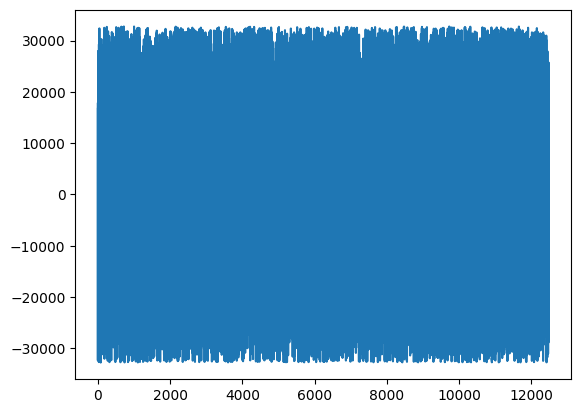

In [ ]:
plt.plot(np.frombuffer(voice_bytes,dtype=np.int16))
plt.show()

In [ ]:
import wave

In [ ]:
obj = wave.open('rec.wav','wb')

In [ ]:
framerate = len(np.frombuffer(voice_bytes,dtype=np.int16))/3

In [ ]:
obj.setsampwidth(2)
obj.setnchannels(1)
obj.setnframes(len(np.frombuffer(voice_bytes,dtype=np.int16)))
obj.setframerate(framerate)

In [ ]:
obj.writeframes(voice_bytes)

In [ ]:
obj.close()

In [ ]:
!pip install ffmpeg-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
from scipy.io.wavfile import read as wav_read
import io
import ffmpeg

AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };            
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {            
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data); 
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});
      
</script>
"""

def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  
  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)
  
  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  sr, audio = wav_read(io.BytesIO(riff))

  return audio, sr

In [ ]:
audio, sr = get_audio()

In [ ]:
audio

array([0, 0, 0, ..., 0, 2, 1], dtype=int16)

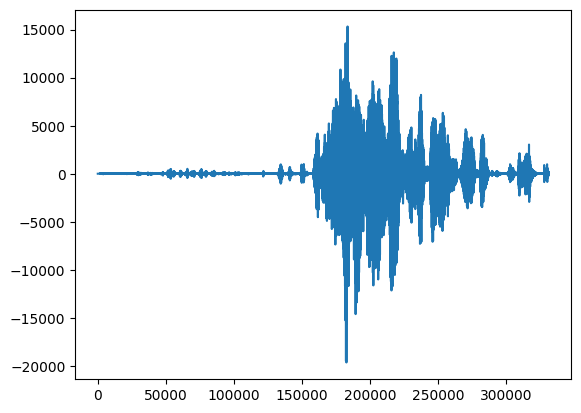

In [ ]:
plt.plot(audio)
plt.show()

In [ ]:
sr

48000

In [ ]:
import wave

In [ ]:
obj = wave.open('rec.wav','wb')

In [ ]:
framerate = sr

In [ ]:
obj.setsampwidth(2)
obj.setnchannels(1)
obj.setnframes(len(audio))
obj.setframerate(framerate)

In [ ]:
obj.writeframes(audio.tobytes())

In [ ]:
obj.close()

# MP3

In [ ]:
!pip install pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pydub import AudioSegment

In [ ]:
audio = AudioSegment.from_wav('rec.wav')

In [ ]:
audio = audio +6 #dB

In [ ]:
audio.fade_in(2000)

In [ ]:
audio.export('rec.mp3',format='mp3')

<_io.BufferedRandom name='rec.mp3'>

In [ ]:
audio2 = AudioSegment.from_mp3('rec.mp3')

In [ ]:
audio2

In [ ]:
len(audio2)

6900